In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l

d2l.gpu_mem_init()

2025-09-22 17:29:54.519291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 17:29:54.582125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 17:29:56.032103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [10]:
def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding='same', activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)
    ])

In [3]:
X = tf.random.uniform((1,28,28,1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:', X.shape)

I0000 00:00:1758533397.000283 2735324 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25749 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:08.0, compute capability: 7.0
2025-09-22 17:29:57.247147: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 7.0
2025-09-22 17:29:57.247172: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/local/cuda/bin/ptxas
2025-09-22 17:29:57.247215: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-22 17:29:57.249569: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-22 17:29:57.251719: W tensorfl

Conv2D output shape: (1, 28, 28, 6)
AveragePooling2D output shape: (1, 14, 14, 6)
Conv2D output shape: (1, 10, 10, 16)
AveragePooling2D output shape: (1, 5, 5, 16)
Flatten output shape: (1, 400)
Dense output shape: (1, 120)
Dense output shape: (1, 84)
Dense output shape: (1, 10)


2025-09-22 17:29:57.897753: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    """一个以可视化的训练进展的回调"""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs], legend=[
                'train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()

    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(
            self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

In [6]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizier = tf.keras.optimizers.SGD(learning_rate=lr)
        net = net_fn()
        net.compile(optimizer=optimizier, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs, device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net


loss 0.460, train acc 0.828, test acc 0.817
62487.5 examples/sec on /GPU:0


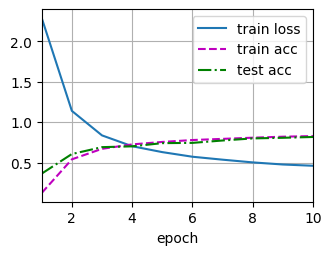

: 

In [11]:
lr, num_epochs = 0.9, 10
my_net = train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [8]:
print(my_net.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (256, 28, 28, 6)       │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (256, 14, 14, 6)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (256, 10, 10, 16)      │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (256, 5, 5, 16)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (256, 400)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (256, 120)             │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (256, 84)              │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (256, 10)              │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,708 (241.05 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [9]:
print(my_net.layers[0].weights[0])

<Variable path=sequential_1/conv2d_2/kernel, shape=(5, 5, 1, 6), dtype=float32, value=[[[[ 0.0236238  -0.0671363  -0.2549461  -0.1710653  -0.17516886
     0.06189606]]

  [[ 0.0038048  -0.25779712 -0.5081462   0.18035842 -0.12409405
    -0.09855445]]

  [[-0.03169788 -0.06622099 -0.4242931  -0.15198247  0.08632638
     0.06808217]]

  [[ 0.11642814 -0.20383248 -0.7324374   0.07244653  0.06033251
     0.00912163]]

  [[-0.16334833  0.04292916 -0.7120578   0.02828484 -0.18945384
    -0.15584998]]]


 [[[-0.04809712 -0.17137174 -0.5042533  -0.05970895 -0.29188314
     0.04172937]]

  [[ 0.09322556  0.09049791 -0.34608358  0.13287675  0.00719729
    -0.13779071]]

  [[-0.07224262  0.07846916 -0.44803333 -0.17889233 -0.16541827
    -0.08281316]]

  [[-0.0067218  -0.22201496 -0.71050465  0.00190177 -0.01793675
     0.05879734]]

  [[ 0.0370747  -0.12030867 -0.49148285  0.04307894  0.01195587
    -0.0066646 ]]]


 [[[-0.16368914 -0.23234528 -0.32090276  0.11207995 -0.2780993
    -0.1720839 ]]